In [1]:
# train_segmentation.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import os
import glob
import random
import math
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import segmentation_models_pytorch as smp
from scipy.stats import zscore


c:\Users\munib\anaconda3\envs\segment-torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# -----------------------------
# Config
# -----------------------------
TRAIN_GLOB = r'training/*_label.tif'
WEIGHTS_PATH = 'deeplab_v3p_resnet50.pth'  # torch checkpoint
LEARNING_RATE = 5e-5
BATCH_SIZE = 4
EPOCHS = 20
VAL_SPLIT = 0.1
RNG_SEED = 42
NUM_WORKERS = 0  # Windows-safe default
LOG_DIR = r'runs/seg_logs'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
# -----------------------------
# Helpers for I/O to match your original data layout
# -----------------------------
def label_to_class_indices(label_path: str) -> np.ndarray:
    """
    read the TIFF and convert to class indices [0, 1].
    """
    lab = tifffile.imread(label_path)
    # lab is expected boolean or 0/1 mask for foreground
    # ensure boolean
    lab_bool = lab.astype(bool)
    # class index: 1 where mask True, else 0
    return lab_bool.astype(np.int64)

def image_to_3ch_zscore(image_path: str) -> np.ndarray:
    """
    Read the RFP TIFF (single channel), z-score across all pixels,
    and replicate to 3 channels (H, W, 3)
    """
    rfp = tifffile.imread(image_path).astype(np.float32)
    rfp_z = zscore(rfp, axis=None)
    # handle any potential NaNs (e.g., constant image)
    if np.isnan(rfp_z).any():
        rfp_z = np.nan_to_num(rfp_z, nan=0.0)
    h, w = rfp.shape[-2], rfp.shape[-1] if rfp.ndim == 3 else rfp.shape[1]
    # Support (H, W) or (Z, H, W) by max projecting
    if rfp.ndim == 3:
        rfp_z = rfp_z.max(axis=0)
    image = np.stack([rfp_z, rfp_z, rfp_z], axis=-1).astype(np.float32)
    return image

# -----------------------------
# Dataset
# -----------------------------
class SegDataset(Dataset):
    def __init__(self, image_paths, label_paths, augment=True):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lab_path = self.label_paths[idx]

        img = image_to_3ch_zscore(img_path)          # (H, W, 3), float32
        lab = label_to_class_indices(lab_path)       # (H, W), int64 in {0,1}

        # Random flips
        if self.augment:
            if random.randint(0, 1):
                img = img[::-1, :, :]
                lab = lab[::-1, :]
            if random.randint(0, 1):
                img = img[:, ::-1, :]
                lab = lab[:, ::-1]

        # To torch tensors: CHW for image, HW for label
        img_t = torch.from_numpy(img.copy()).permute(2, 0, 1).contiguous() # (3, H, W)
        lab_t = torch.from_numpy(lab.copy())      # (H, W), long class indices
        return img_t, lab_t

In [5]:
# -----------------------------
# Get data
# -----------------------------
label_paths = sorted(glob.glob(TRAIN_GLOB))
if len(label_paths) == 0:
    raise FileNotFoundError(f'No label files found with pattern: {TRAIN_GLOB}')
image_paths = [p[:-10] + '.tif' for p in label_paths]  # strip "_label.tif" -> ".tif"

# Quick shape sanity check on one sample
_debug_img = image_to_3ch_zscore(image_paths[0])
_debug_lab = label_to_class_indices(label_paths[0])
print('Sample image shape:', _debug_img.shape, 'label shape:', _debug_lab.shape)

Sample image shape: (512, 512, 3) label shape: (512, 512)


In [16]:
_debug_img.shape

(512, 512, 3)

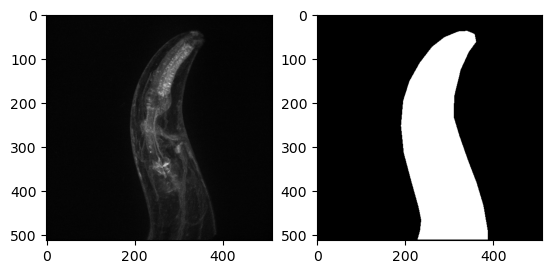

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(_debug_img[:,:,0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(_debug_lab[:,:],cmap='gray')
plt.show()

In [20]:
# -----------------------------
# Dataset & Dataloaders
# -----------------------------
random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

dataset = SegDataset(image_paths, label_paths, augment=True)

val_len = max(1, int(len(dataset) * VAL_SPLIT))
train_len = len(dataset) - val_len
train_ds, val_ds = random_split(dataset, [train_len, val_len],
                                generator=torch.Generator().manual_seed(RNG_SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [22]:
# -----------------------------
# Model (DeepLabV3+ ResNet-50)
# -----------------------------
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',       # backbone
    encoder_weights='imagenet',    # start from ImageNet weights
    in_channels=3,
    classes=2                      # background, foreground
).to(DEVICE)

In [23]:
# Loss & Optimizer to mirror binary crossentropy semantics
# We use CrossEntropyLoss on class indices (more stable than BCE on one-hot).
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [31]:
# Try to resume if a weights file exists
if os.path.isfile(WEIGHTS_PATH):
    print(f'Loading existing weights: {WEIGHTS_PATH}')
    ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt.get('optimizer', optimizer.state_dict()))

# -----------------------------
# Training loop with TensorBoard
# -----------------------------
writer = SummaryWriter(LOG_DIR)

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labs = labs.to(DEVICE, non_blocking=True)
            logits = model(imgs)                # (B, 2, H, W)
            loss = criterion(logits, labs)
            total_loss += float(loss.item()) * imgs.size(0)
            n += imgs.size(0)
    return total_loss / max(1, n)

best_val = math.inf
global_step = 0

try:
    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        for imgs, labs in train_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labs = labs.to(DEVICE, non_blocking=True)
            
            if imgs.shape[0]==1:
                continue

            optimizer.zero_grad(set_to_none=True)
            logits = model(imgs)
            loss = criterion(logits, labs)
            loss.backward()
            optimizer.step()

            writer.add_scalar('train/loss', loss.item(), global_step)
            global_step += 1

        val_loss = evaluate(val_loader)
        writer.add_scalar('val/loss', val_loss, epoch)
        print(f'Epoch {epoch:03d} | val_loss: {val_loss:.6f}')

        # save best
        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
            }, WEIGHTS_PATH)
            print(f'  -> Saved best to {WEIGHTS_PATH}')
except KeyboardInterrupt:
    print('Training interrupted')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001 | val_loss: 0.091149


  5%|▌         | 1/20 [00:06<02:05,  6.58s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 002 | val_loss: 0.069991


 10%|█         | 2/20 [00:12<01:52,  6.27s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 003 | val_loss: 0.055442


 15%|█▌        | 3/20 [00:18<01:44,  6.16s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 004 | val_loss: 0.046594


 20%|██        | 4/20 [00:24<01:39,  6.20s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 005 | val_loss: 0.043116


 25%|██▌       | 5/20 [00:30<01:31,  6.13s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 006 | val_loss: 0.038749


 30%|███       | 6/20 [00:36<01:24,  6.01s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 007 | val_loss: 0.033949


 35%|███▌      | 7/20 [00:42<01:16,  5.92s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 008 | val_loss: 0.031046


 40%|████      | 8/20 [00:48<01:10,  5.87s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


 45%|████▌     | 9/20 [00:53<01:03,  5.73s/it]

Epoch 009 | val_loss: 0.031175
Epoch 010 | val_loss: 0.028332


 50%|█████     | 10/20 [00:59<00:58,  5.86s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 011 | val_loss: 0.026729


 55%|█████▌    | 11/20 [01:05<00:53,  5.89s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 012 | val_loss: 0.024726


 60%|██████    | 12/20 [01:11<00:47,  5.93s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 013 | val_loss: 0.022573


 65%|██████▌   | 13/20 [01:17<00:41,  5.97s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 014 | val_loss: 0.020541


 70%|███████   | 14/20 [01:23<00:35,  6.00s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


 75%|███████▌  | 15/20 [01:29<00:29,  5.90s/it]

Epoch 015 | val_loss: 0.021565


 80%|████████  | 16/20 [01:35<00:23,  5.82s/it]

Epoch 016 | val_loss: 0.020832


 85%|████████▌ | 17/20 [01:40<00:17,  5.79s/it]

Epoch 017 | val_loss: 0.021236
Epoch 018 | val_loss: 0.019552


 90%|█████████ | 18/20 [01:47<00:12,  6.07s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 019 | val_loss: 0.018722


 95%|█████████▌| 19/20 [01:53<00:06,  6.08s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]

Epoch 020 | val_loss: 0.020820


In [33]:
label_paths

['training\\021825_eft_41z_fed_worm001_0_label.tif',
 'training\\021825_eft_41z_fed_worm001_100_label.tif',
 'training\\021825_eft_41z_fed_worm001_150_label.tif',
 'training\\021825_eft_41z_fed_worm001_200_label.tif',
 'training\\021825_eft_41z_fed_worm001_250_label.tif',
 'training\\021825_eft_41z_fed_worm001_300_label.tif',
 'training\\021825_eft_41z_fed_worm001_350_label.tif',
 'training\\021825_eft_41z_fed_worm001_400_label.tif',
 'training\\021825_eft_41z_fed_worm001_50_label.tif',
 'training\\022025_eft_41z_starved_worm002_0_label.tif',
 'training\\022025_eft_41z_starved_worm002_1000_label.tif',
 'training\\022025_eft_41z_starved_worm002_100_label.tif',
 'training\\022025_eft_41z_starved_worm002_1050_label.tif',
 'training\\022025_eft_41z_starved_worm002_1100_label.tif',
 'training\\022025_eft_41z_starved_worm002_1150_label.tif',
 'training\\022025_eft_41z_starved_worm002_150_label.tif',
 'training\\022025_eft_41z_starved_worm002_200_label.tif',
 'training\\022025_eft_41z_starved

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67152447..32.877743].


Random example index: 130


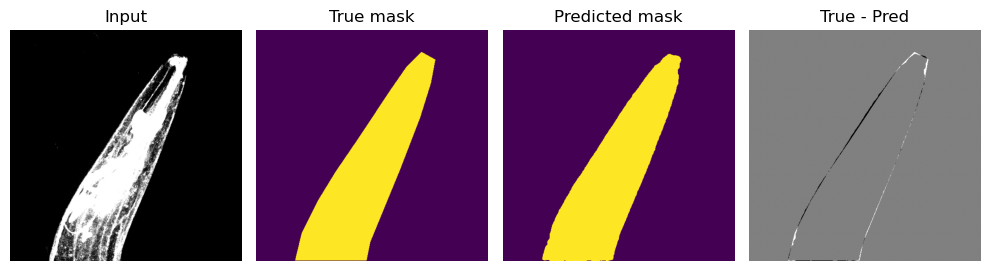

In [70]:
# -----------------------------
# Quick visualization 
# -----------------------------
# pick a random image from the whole set
i = np.random.randint(0, len(image_paths))
print('Random example index:', i)

with torch.no_grad():
    model.eval()
    img_np = image_to_3ch_zscore(image_paths[i])  # (H, W, 3)
    img_t = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    logits = model(img_t)               # (1, 2, H, W)
    pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
true_label = label_to_class_indices(label_paths[i])

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.title('Input')
plt.imshow(img_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('True mask')
plt.imshow(true_label, cmap='viridis')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted mask')
plt.imshow(pred, cmap='viridis')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('True - Pred')
plt.imshow(true_label-pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()